# TP4 - Problema 1

### Grupo 11

Nelson Almeida a95652
<br>
Nuno Costa a97610

**Equações de Fluxo**

1. Durante  a travagem não existe qualquer  força no sistema excepto as forças de atrito. Quando uma superfície se desloca em relação à outra, a força de atrito  é proporcional à força de compressão entre elas. 
2. No contacto rodas/solo o atrito é constante porque a força de compressão é o peso; tem-se $f = a\, P$ sendo  $a$ a constante de atrito e $P$ o peso. Ambos são fixos e independentes do modo.
3. No contacto corpo/rodas,  a força de compressão é a força de travagem que aqui se assume como proporcional à diferença de velocidades

$$F =  c\, (V-v)$$
A  constante de proporcionalidade $c$ depende do modo: é elevada no modo Stopping e baixa nos outros.

4. As  equações que traduzem a dinâmica  do sistema são, em todos os modo excepto Blocked,

$$(\dot{V} \,=\, -F)\,\land\, (\dot{v} \,=\, -a\, P  + F)$$ 
e , no modo Blocked,  a dinâmica do sistema é  regida por
$$(V = v) \;\land\; (\,\dot{v}\,=\, -a\, P\,)$$

6. Tanto no modo Blocked  como no modo Free  existe um “timer” que impede que o controlo aí permaneça mais do que $\,\tau\,$ segundos.  Os     $\mathsf{switch}(V,v,t,V',v',t')\,$  nesses modos devem forçar esta condição. 
7. Todos os “switchs” devem ser construídos de  modo a impedir a existência de trajetórias de Zenão.
8. No instante inicial assume-se $\,V = v\,=\,V_0$  ,  em que a velocidade $V_0$ é o “input” do problema.

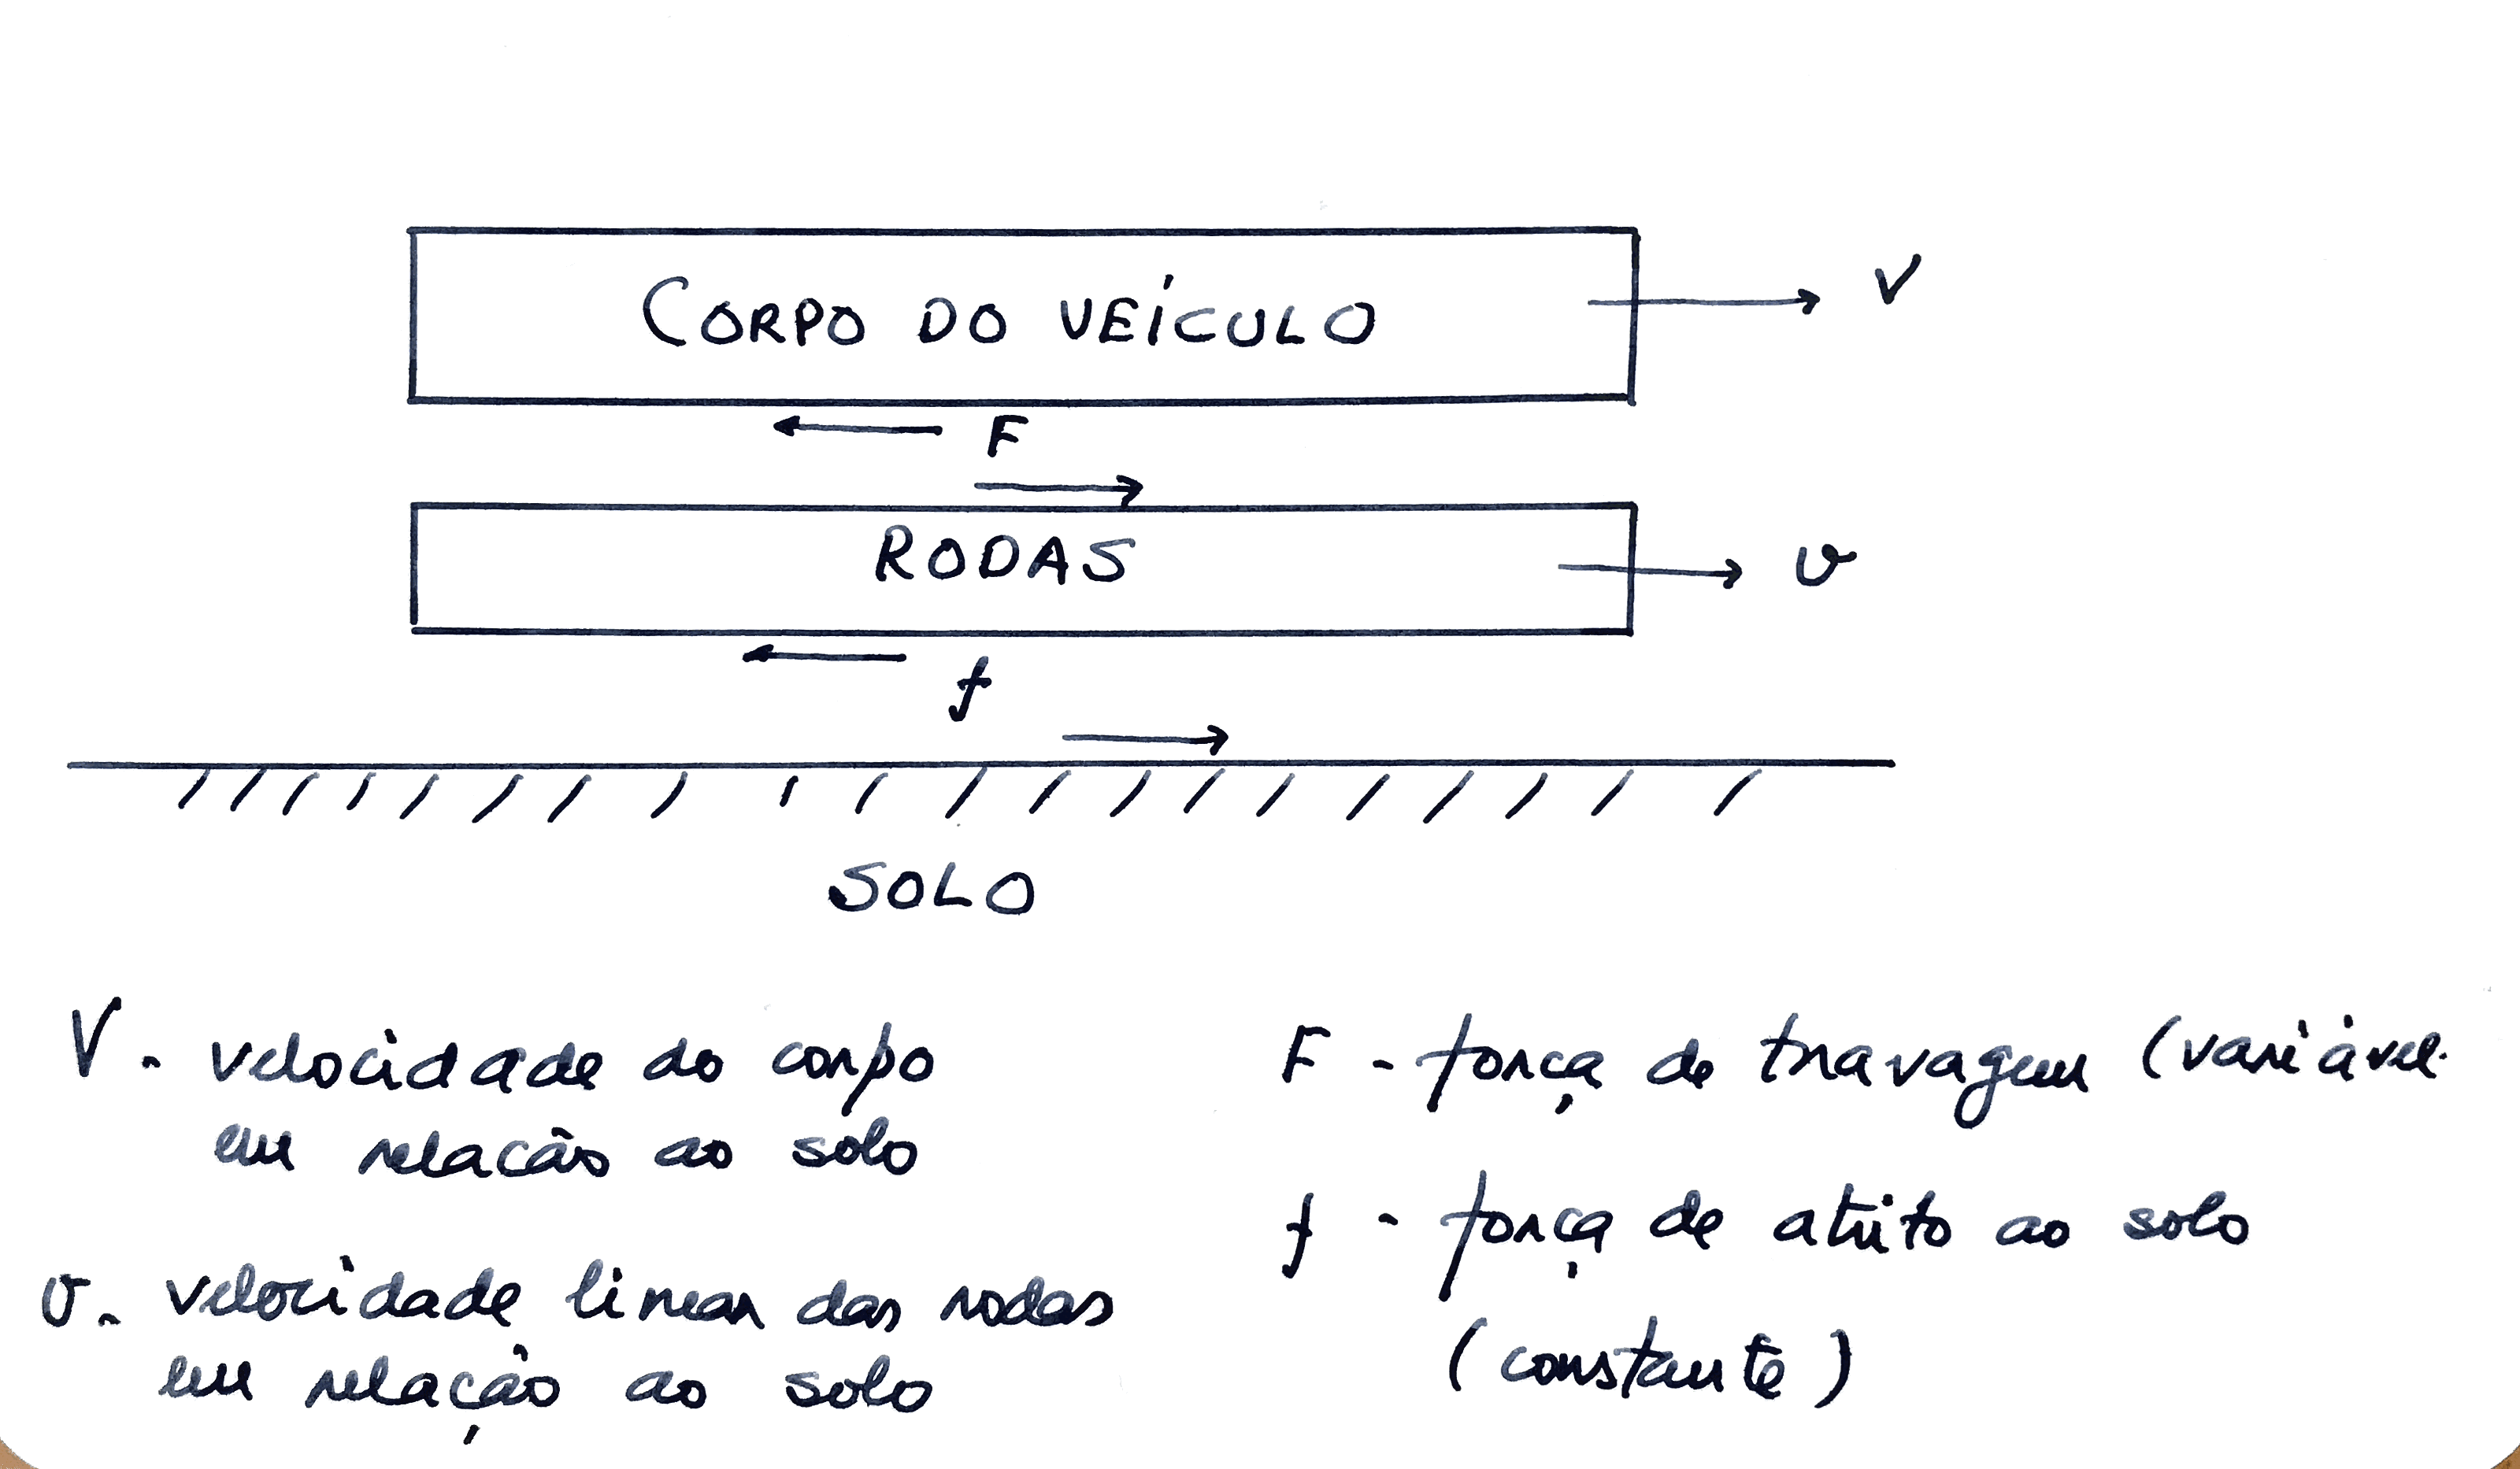


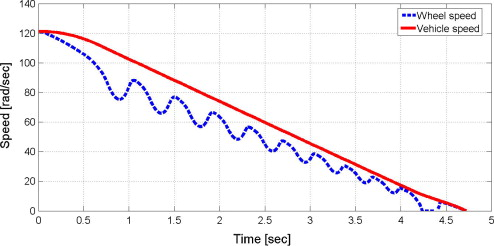

In [2]:
import random as rd
from z3 import *
import matplotlib.pyplot as plt

In [3]:
#state 0 Start
#state 1 Free
#state 2 Stopping
#state 3 Blocked
#state 4 Stopped


def declare(i):
    state = {}
    state["state"] = Int("state"+str(i))  
    state["V"] = Real("V"+str(i))  
    state["v"] = Real("v"+str(i))  
    state["t"] = Real("t"+str(i))  
    state["timer"] = Real("timer"+str(i))
    return state


In [4]:
def init(state, vInit):
    return And(state["t"] == 0,
               state["V"] == vInit,
               state["v"] == vInit,
               state["state"] == 0)

In [5]:
def trans(curr, prox, atrito, forcaCompressaoLow, forcaCompressaoHigh, 
           pesoVeiculo, deltaTempo, tempoTransBlockedFree, tempoMaximo,vInit, precisaoVelocidade):

    # Estado atual igual ao futuro
    tt = (curr["t"] == prox["t"])
    vv = (curr["V"] == prox["V"])
    rr = (curr["v"] == prox["v"])

    # untimed
    start_free = And(curr["state"]==0,
                    prox["state"]==2,
                    tt,vv,rr)
    start_stopping = And(curr["state"] == 0,
                         prox["state"] == 2,
                         tt, vv, rr)

    stopping_blocked = And(curr["state"] == 2,
                           prox["state"] == 3,
                           curr["V"] > 0,
                           curr["v"] >= 0,
                           prox["timer"] == 0,
                           curr["V"]-curr["v"] < precisaoVelocidade,
                           tt, vv, rr)

    all_stopped = And(Or(curr["state"] == 2,
                         curr["state"] == 3,
                         curr["state"] == 1),
                      prox["state"] == 4,
                      curr["V"] < precisaoVelocidade,
                      curr["v"] < precisaoVelocidade,
                      prox["V"] == 0,
                      prox["v"] == 0,
                      tt)

    blocked_free = And(curr["state"] == 3,
                       prox["state"] == 1,
                       curr["V"] > 0,
                       curr["v"] >= 0,
                       curr["timer"] >= tempoTransBlockedFree,
                       prox["timer"] == 0,
                       tt, vv, rr)

    free_stopping = And(curr["state"] == 1,
                        prox["state"] == 2,
                        curr["V"] > 0,
                        curr["v"] >= 0,
                        curr["timer"] >= tempoTransBlockedFree,
                        tt, vv, rr)

    # timed
    stopping = Or([And(curr["state"] == 2,
                       prox["state"] == 2,
                       prox["t"] > curr["t"],
                       curr["V"]-curr["v"] >= precisaoVelocidade,
                       prox["V"]-prox["v"] >= 0,
                       curr["V"] >= 0,
                       curr["v"] >= 0,
                       prox["V"] >= 0,
                       prox["v"] >= 0,
                       curr["V"]-curr["v"] < i+0.5,
                       curr["V"]-curr["v"] >= i-0.5,

                       # Equaçoes do stopping/free
                       prox["V"] == (curr["V"]+((-forcaCompressaoHigh*i))*(prox["t"]-curr["t"])),
                       prox["v"] == (curr["v"]+(-atrito*pesoVeiculo + forcaCompressaoHigh*i)*(prox["t"]-curr["t"]))) for i in range(vInit+1)])

    free = Or([And(curr["state"] == 1,
                   prox["state"] == 1,
                   prox["t"] > curr["t"],
                   prox["V"]-prox["v"] >= 0,
                   curr["V"] >= 0,
                   curr["v"] >= 0,
                   prox["V"] >= 0,
                   prox["v"] >= 0,
                   prox["timer"] <= tempoTransBlockedFree,
                   prox["timer"] == curr["timer"]+prox["t"]-curr["t"],
                   curr["V"]-prox["v"] < i+0.5,
                   curr["v"]-prox["v"] >= i-0.5,

                   # Equaçoes do stopping/free
                   prox["V"] == (curr["V"]+(-forcaCompressaoLow*i)*(prox["t"]-curr["t"])),
                   prox["v"] == (curr["v"]+(-atrito*pesoVeiculo + forcaCompressaoLow*i)*(prox["t"]-curr["t"]))
                )for i in range(vInit+1)])

    blocked = And(curr["state"] == 3,
                  prox["state"] == 3,
                  prox["t"] > curr["t"],
                  curr["V"] >= 0,
                  curr["v"] >= 0,
                  prox["V"] >= 0,
                  prox["v"] >= 0,
                  prox["timer"] <= tempoTransBlockedFree,
                  prox["timer"] == curr["timer"]+prox["t"]-curr["t"],

                  # Equaçoes do blocked
                  prox["V"] == curr["V"] + (-atrito*pesoVeiculo) * (prox["t"]-curr["t"]),
                  prox["v"] == curr["v"] + (-atrito*pesoVeiculo) * (prox["t"]-curr["t"]))

    # Acabou
    end = And(curr["state"] == 4,
              prox["state"] == 4,
              tt, vv, rr)

    return Or(start_stopping, stopping_blocked, all_stopped, blocked_free, free_stopping, stopping, free, blocked, end)


In [6]:
def gera_traco(declare, init,trans, atrito, forcaCompressaoLow, forcaCompressaoHigh, 
           pesoVeiculo, deltaTempo, tempoTransBlockedFree, tempoMaximo,vInit, precisaoVelocidade,k):
    s = Solver()
    
    #Gerar o traço
    trace = [declare(i) for i in range(k)]

    #Gerar o primeiro estado
    s.add(init(trace[0],vInit))

    #Gerar as condições lógicas do traço
    for i in range(k-1):
        s.add(trans(trace[i], trace[i+1],
                   atrito, forcaCompressaoLow, forcaCompressaoHigh, 
                   pesoVeiculo, deltaTempo, tempoTransBlockedFree, 
                   tempoMaximo,vInit, precisaoVelocidade))
        
    vL=[]
    V=[]
    t=[]

    if s.check() == sat:
        m = s.model()
        for i in range(k):
            print(i)
            for v in trace[i]:
                if v != "timer":
                    if trace[i][v].sort() == RealSort():
                        print(v, '=', round(m[trace[i][v]].numerator_as_long()/m[trace[i][v]].denominator_as_long(),4))
                        if v=="v":
                            vL.append(round(m[trace[i][v]].numerator_as_long()/m[trace[i][v]].denominator_as_long(),4))
                        if v=="V":
                            V.append(round(m[trace[i][v]].numerator_as_long()/m[trace[i][v]].denominator_as_long(),4))
                        if v=="t":
                            t.append(round(m[trace[i][v]].numerator_as_long()/m[trace[i][v]].denominator_as_long(),4))
                    else:
                        print(v, "=", m[trace[i][v]])
     
    
    fig ,ax = plt.subplots()
    # Plot the two lines
    line1, = ax.plot(t, vL, color='red', linestyle='solid', label='vRoda')
    line2 ,= ax.plot(t, V, color='blue', linestyle='solid', label='vCarro')

    ax.set_xlabel('t')
    ax.set_ylabel('v')
    
    ax.legend([line1, line2], ["vRoda","vCarro"])

    # Show the plot
    plt.show()


0
state = 0
V = 20.0
v = 20.0
t = 0.0
1
state = 2
V = 20.0
v = 20.0
t = 0.0
2
state = 3
V = 20.0
v = 20.0
t = 0.0
3
state = 3
V = 14.0
v = 14.0
t = 0.3
4
state = 1
V = 14.0
v = 14.0
t = 0.3
5
state = 1
V = 14.0
v = 13.5
t = 0.325
6
state = 1
V = 14.0
v = 8.0
t = 0.6
7
state = 2
V = 14.0
v = 8.0
t = 0.6
8
state = 2
V = 13.0137
v = 8.5166
t = 0.6235
9
state = 2
V = 12.9303
v = 8.5405
t = 0.6265
10
state = 2
V = 11.4581
v = 8.9611
t = 0.679
11
state = 2
V = 7.0883
v = 7.0883
t = 0.9912


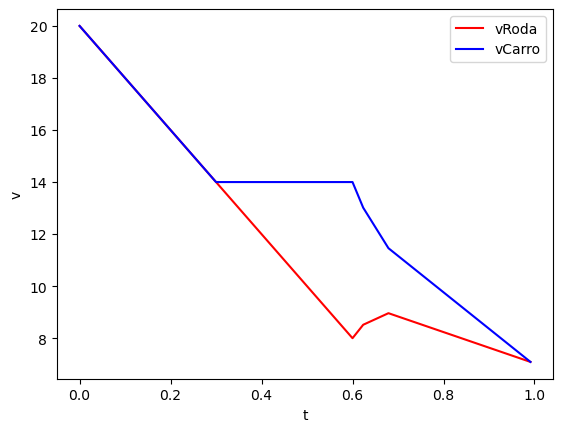

In [15]:

atrito = 0.02

forcaCompressaoLow = 0
forcaCompressaoHigh = 7

pesoVeiculo = 1000

deltaTempo = 0.1
tempoTransBlockedFree = 0.3
tempoMaximo = 20

vInit = 20

# Esta constante existe para não entrarmos num infinito de nunca chegar a velocidade 0
precisaoVelocidade = 0.5
k=12

gera_traco(declare, init,trans, atrito, forcaCompressaoLow, forcaCompressaoHigh, 
           pesoVeiculo, deltaTempo, tempoTransBlockedFree, tempoMaximo,vInit, precisaoVelocidade, k)

## Resultados não satisfatórios
Visto que obtivemos um gráfico e valores que não vão de acordo com as nossas métricas vamos então elaborar mais exemplos com valores diferentes de forma a aproximarmos o mais possível os resultados das nossas expectativas

0
state = 0
V = 20.0
v = 20.0
t = 0.0
1
state = 2
V = 20.0
v = 20.0
t = 0.0
2
state = 3
V = 20.0
v = 20.0
t = 0.0
3
state = 3
V = 19.25
v = 19.25
t = 0.001
4
state = 1
V = 19.25
v = 19.25
t = 0.001
5
state = 1
V = 19.25
v = 19.2422
t = 0.001
6
state = 1
V = 19.25
v = 19.2344
t = 0.001
7
state = 1
V = 19.25
v = 19.0078
t = 0.0013
8
state = 1
V = 19.25
v = 19.0
t = 0.0013
9
state = 1
V = 19.25
v = 18.5
t = 0.002
10
state = 2
V = 19.25
v = 18.5
t = 0.002
11
state = 2
V = 18.51
v = 18.5
t = 0.003
12
state = 2
V = 18.51
v = 0.0
t = 0.0277
13
state = 2
V = 15.4238
v = 2.9238
t = 0.0279
14
state = 2
V = 9.1838
v = 8.6838
t = 0.0285
15
state = 2
V = 9.1838
v = 8.1512
t = 0.0292
16
state = 2
V = 9.176
v = 8.1512
t = 0.0292
17
state = 2
V = 8.1612
v = 8.1512
t = 0.0306
18
state = 2
V = 8.1612
v = 5.6612
t = 0.0339
19
state = 2
V = 7.4945
v = 5.9946
t = 0.0343
20
state = 2
V = 6.0046
v = 5.9946
t = 0.0363
21
state = 2
V = 6.0046
v = 0.5046
t = 0.0437
22
state = 2
V = 3.01
v = 3.0
t = 0.0443
23
st

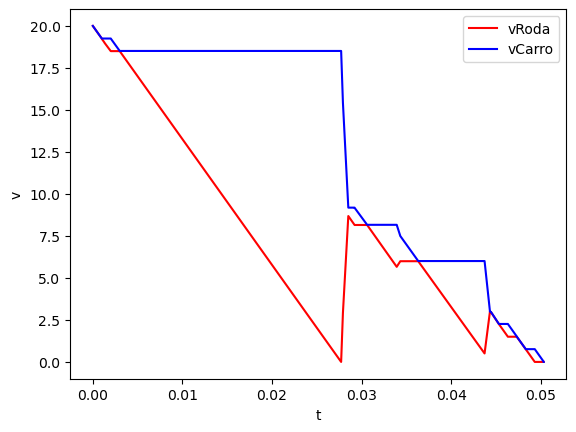

In [25]:
#dados veiculo e pneus
atrito = 0.5 
pesoVeiculo = 1500

forcaCompressaoLow = 0
forcaCompressaoHigh = atrito*pesoVeiculo


deltaTempo = 0.1
tempoTransBlockedFree = 0.001
tempoMaximo = 20

vInit = 20

# Esta constante existe para não entrarmos num infinito de nunca chegar a velocidade 0
precisaoVelocidade = 0.01
k=100

gera_traco(declare, init,trans, atrito, forcaCompressaoLow, forcaCompressaoHigh, 
           pesoVeiculo, deltaTempo, tempoTransBlockedFree, tempoMaximo,vInit, precisaoVelocidade, k)

0
state = 0
V = 20.0
v = 20.0
t = 0.0
1
state = 2
V = 20.0
v = 20.0
t = 0.0
2
state = 3
V = 20.0
v = 20.0
t = 0.0
3
state = 3
V = 20.0
v = 20.0
t = 0.0
4
state = 3
V = 19.997
v = 19.997
t = 0.001
5
state = 1
V = 19.997
v = 19.997
t = 0.001
6
state = 1
V = 19.997
v = 19.994
t = 0.002
7
state = 2
V = 19.997
v = 19.994
t = 0.002
8
state = 3
V = 19.997
v = 19.994
t = 0.002
9
state = 3
V = 19.997
v = 19.994
t = 0.002
10
state = 3
V = 19.997
v = 19.994
t = 0.002
11
state = 3
V = 19.994
v = 19.991
t = 0.003
12
state = 1
V = 19.994
v = 19.991
t = 0.003
13
state = 1
V = 19.994
v = 19.988
t = 0.004
14
state = 1
V = 19.994
v = 19.988
t = 0.004
15
state = 2
V = 19.994
v = 19.988
t = 0.004
16
state = 3
V = 19.994
v = 19.988
t = 0.004
17
state = 3
V = 19.994
v = 19.988
t = 0.004
18
state = 3
V = 19.991
v = 19.985
t = 0.005
19
state = 1
V = 19.991
v = 19.985
t = 0.005
20
state = 1
V = 19.991
v = 19.982
t = 0.006
21
state = 2
V = 19.991
v = 19.982
t = 0.006
22
state = 3
V = 19.991
v = 19.982
t = 0.006

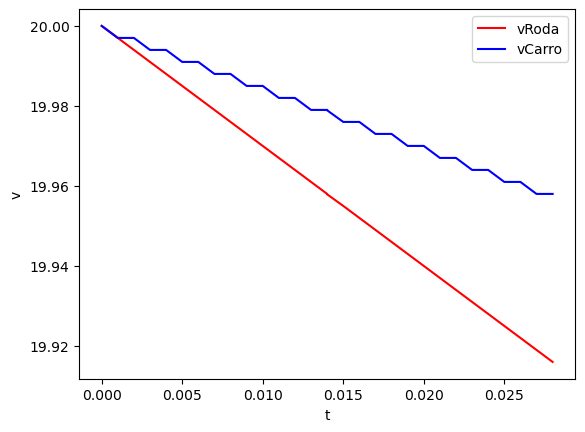

In [8]:
#dados veiculo e pneus
atrito = 0.002
pesoVeiculo = 1500

forcaCompressaoLow = 0
forcaCompressaoHigh = atrito*pesoVeiculo


deltaTempo = 0.1
tempoTransBlockedFree = 0.001
tempoMaximo = 20

vInit = 20

# Esta constante existe para não entrarmos num infinito de nunca chegar a velocidade 0
precisaoVelocidade = 0.05
k=100

gera_traco(declare, init,trans, atrito, forcaCompressaoLow, forcaCompressaoHigh, 
           pesoVeiculo, deltaTempo, tempoTransBlockedFree, tempoMaximo,vInit, precisaoVelocidade, k)

# Propriedades que pretendemos demonstrar:

1. ”o veículo imobiliza-se completamente em menos de $t$ segundos” 
2. “a velocidade $V$ diminui sempre com o tempo”.

In [7]:
def p_imobiliza(curr, t):
    return Implies(
        curr["state"]==4,
        curr["t"]<=t
    )

In [8]:
def p_diminui(curr, prox):
    return And(curr["V"]>prox["V"], curr["t"]<prox["t"])


In [11]:
def bmc_always(declare, init,trans, atrito, forcaCompressaoLow, forcaCompressaoHigh, 
           pesoVeiculo, deltaTempo, tempoTransBlockedFree, tempoMaximo,vInit, precisaoVelocidade, p_diminui, p_imobiliza,K):
    
    for k in range(1, K+1):
        s = Solver()

        #Gerar o traço
        trace = [declare(i) for i in range(k)]

        #Gerar o primeiro estado
        s.add(init(trace[0], vInit))

        #Gerar as condições lógicas do traço
        for i in range(k-1):
            s.add(trans(trace[i], trace[i+1],
                   atrito, forcaCompressaoLow, forcaCompressaoHigh, 
                   pesoVeiculo, deltaTempo, tempoTransBlockedFree, 
                   tempoMaximo,vInit, precisaoVelocidade))

            #Propriedade2
            s.add(Or(Not(p_diminui(trace[i],trace[i+1]))))
        
        #Propriedade1
        s.add(Or(Not(p_imobiliza(trace[k-1], tempoMaximo))))

           
        vL=[]
        V=[]
        t=[]


        if s.check() == sat:
            print("Propriedades falsas")
            m = s.model()
            for i in range(k):
                print(i)
                for v in trace[i]:
                    if v != "timer":
                        if trace[i][v].sort() == RealSort():
                            print(v, '=', round(m[trace[i][v]].numerator_as_long()/m[trace[i][v]].denominator_as_long(),4))
                            if v=="v":
                                vL.append(round(m[trace[i][v]].numerator_as_long()/m[trace[i][v]].denominator_as_long(),4))
                            if v=="V":
                                V.append(round(m[trace[i][v]].numerator_as_long()/m[trace[i][v]].denominator_as_long(),4))
                            if v=="t":
                                t.append(round(m[trace[i][v]].numerator_as_long()/m[trace[i][v]].denominator_as_long(),4))
                        else:
                            print(v, "=", m[trace[i][v]])
            return

    print("Propriedades verdadeiras")

In [14]:

atrito = 0.02

forcaCompressaoLow = 0
forcaCompressaoHigh = 7

pesoVeiculo = 1000

deltaTempo = 0.1
tempoTransBlockedFree = 0.3
tempoMaximo = 20

vInit = 20

# Esta constante existe para não entrarmos num infinito de nunca chegar a velocidade 0
precisaoVelocidade = 0.5
k=10

bmc_always(declare, init,trans, atrito, forcaCompressaoLow, forcaCompressaoHigh, 
           pesoVeiculo, deltaTempo, tempoTransBlockedFree, tempoMaximo,vInit, precisaoVelocidade, p_diminui,p_imobiliza, k)



Propriedades verdadeiras
